# Clustering embeddings to help GPT extract high-level insights

In [2]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import openai
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from sklearn.cluster import KMeans
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pickle

# Generate embeddings

<br>

Let's use the OpenAI API to generate embeddings for us.

<br>

<div>
    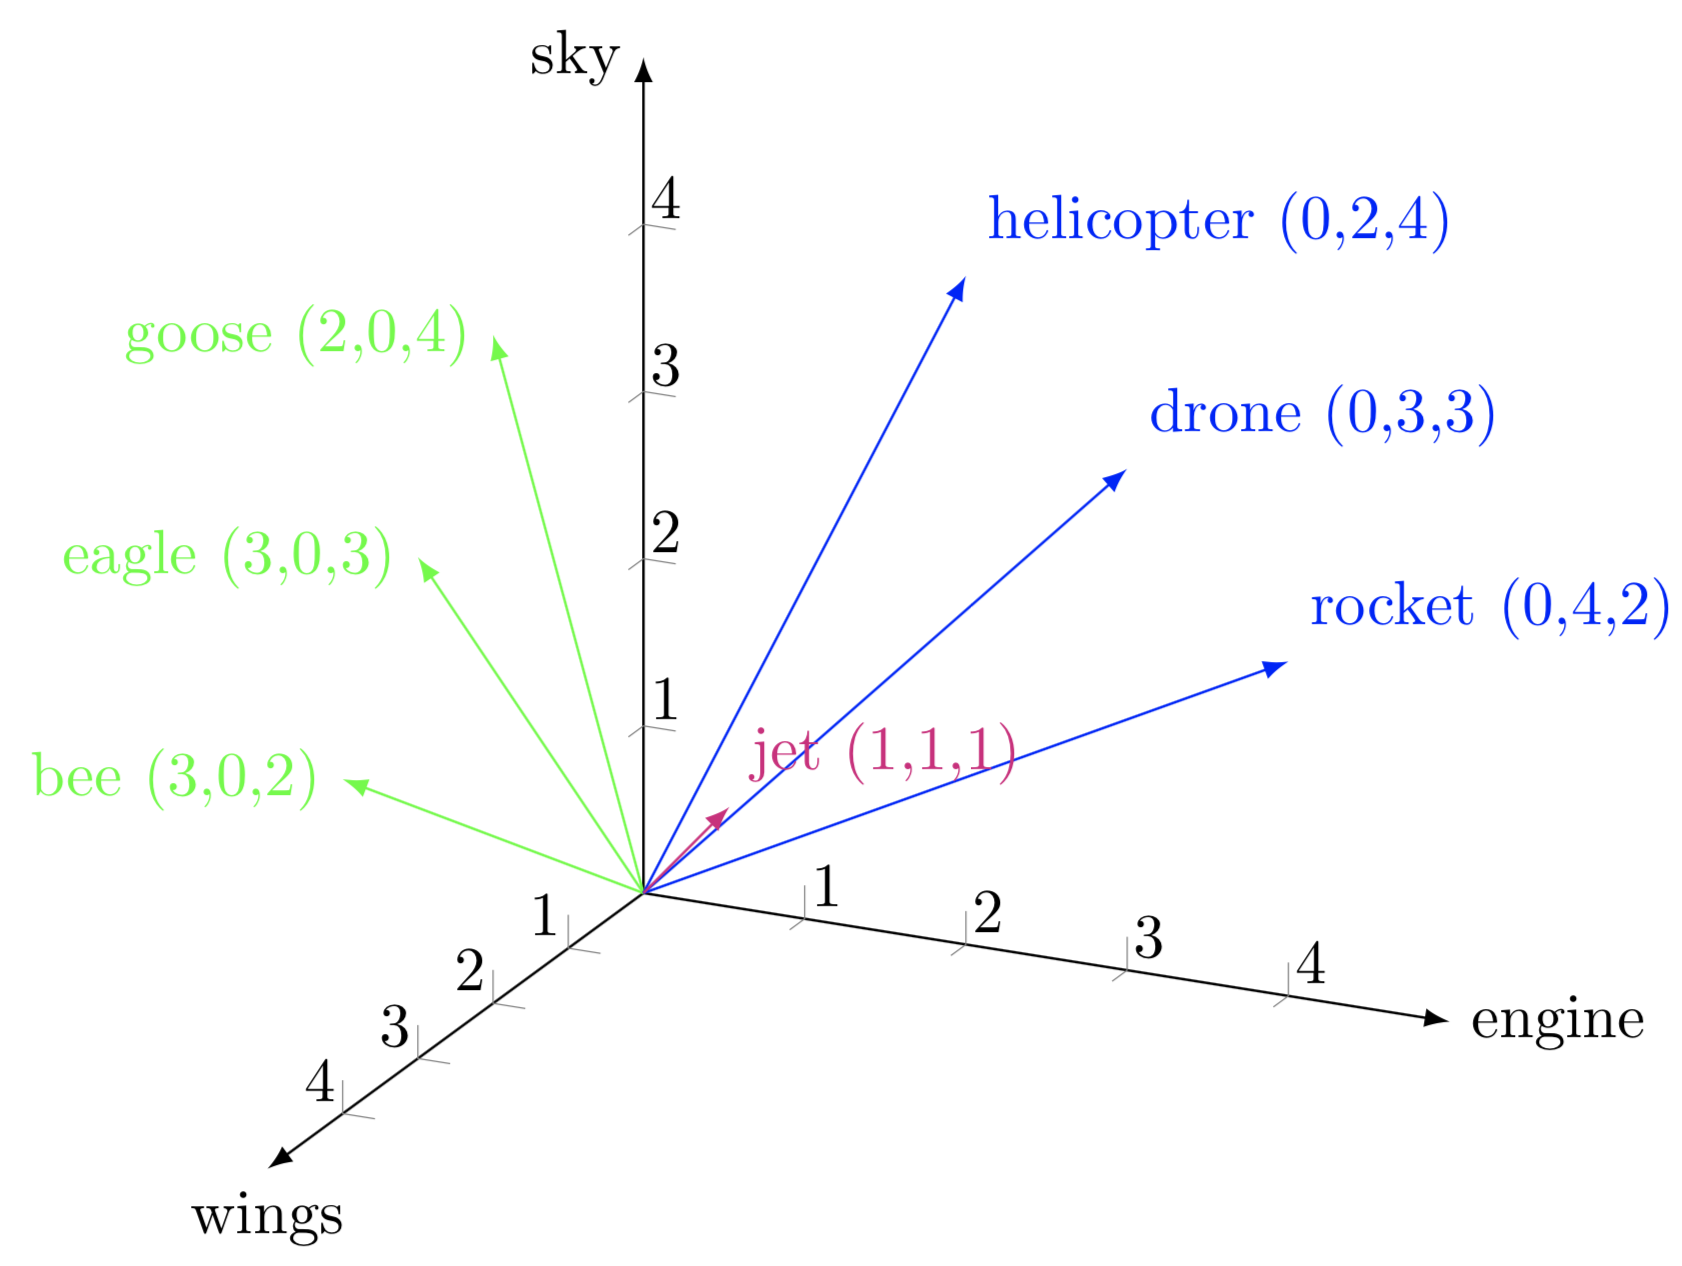
</div>

In [3]:
# # Function to generate embeddings for a given text
# def generate_embedding(text, model="text-embedding-ada-002"):
#     openai.api_key = api_key
#     return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

# # Function to process a single row and generate embeddings for both columns
# def process_row(row):
#     print(row)
#     return generate_embedding(row)

# # Create a DataFrame (you can load your own data using pd.read_csv or another method)
# df = pd.read_csv('aita.csv')

# # Extract the results and add them as new columns to the DataFrame
# df["title_embedding"] = df["title"].apply(process_row).apply(literal_eval)

# print("Finished title embeddings.")

# print("Done")

df = pd.read_pickle("data/post_data_compressed.pkl")[["title", "title_embedding"]]
df.head()

,title,title_embedding
0,AITA Monthly Open Forum Spooktober 2022,"[-0.0016421317122876644, -0.03590385988354683,..."
1,AITA for asking my friend to move a picture of...,"[-0.008650328032672405, 0.006163689307868481, ..."
2,AITA for asking my husband to stay with me whi...,"[0.006464043166488409, -0.01260389108210802, 0..."
3,AITA for telling my SIL to stop talking about ...,"[-0.012339530512690544, -0.01519016083329916, ..."
4,"AITA for wanting to meet my ""daughter"" after g...","[-0.003954039420932531, -0.010664722882211208,..."


# What is clustering?

Clustering is an unsupervised machine learning tasks that aims to group unstructured data into a number of clusters.

Today we're using k-means, which does this by minimizing the in-cluster variances, or the sum of the squared distances of each sample to the center of the cluster.

# How many clusters should we use?

<br>

We calculate the inertias of k-means models fit with different numbers of clusters to evaluate.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


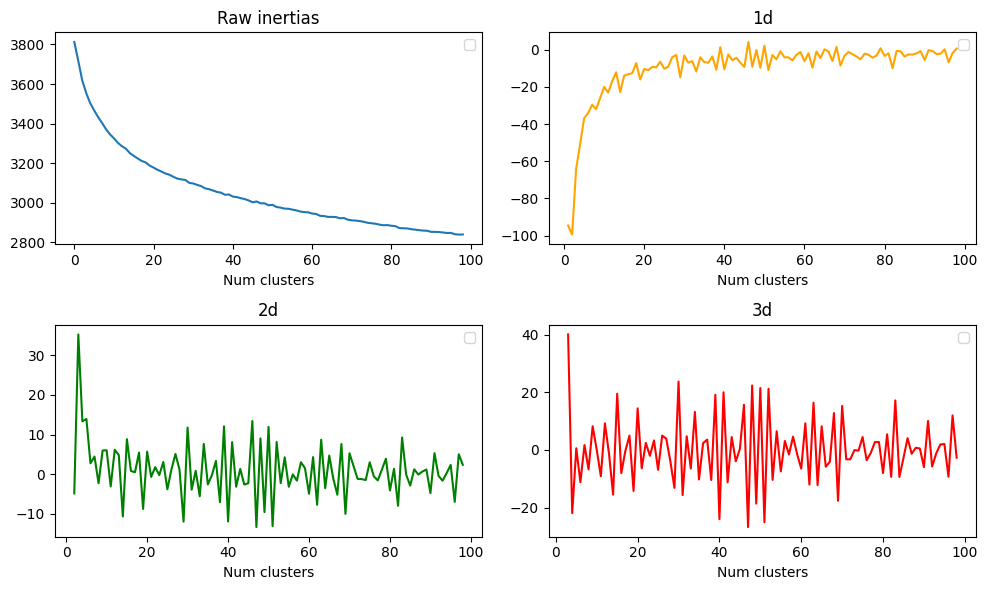

In [4]:
# import pandas as pd
# from sklearn.cluster import KMeans

# inertias = []

# K = range(1, 100)

# for i in K:    
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42).fit(X)
    
#     inertias.append(km.inertia_)

inertias_df = pd.read_pickle('data/inertias.pkl')

# Calculate 1st, 2nd, 3rd derivs
inertias_df["1d"] = inertias_df["inertias"].diff()
inertias_df["2d"] = inertias_df["1d"].diff()
inertias_df["3d"] = inertias_df["2d"].diff()

# Plot 1st, 2nd, 3rd derivs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes[0, 0].plot(inertias_df.index, inertias_df["inertias"])
axes[0, 1].plot(inertias_df.index, inertias_df["1d"], color='orange')
axes[1, 0].plot(inertias_df.index, inertias_df["2d"], color='green')
axes[1, 1].plot(inertias_df.index, inertias_df["3d"], color='red')

for ax in axes.flat:
    ax.set_xlabel('Num clusters')
    ax.legend()

axes[0, 0].set_title('Raw inertias')
axes[0, 1].set_title('1d')
axes[1, 0].set_title('2d')
axes[1, 1].set_title('3d')

plt.tight_layout()
plt.show()

# Fit the model

In [5]:
# Convert column to a numpy list
X = np.array(df["title_embedding"].to_list())

X

array([[-0.00164213, -0.03590386, -0.00512815, ..., -0.01357972,
         0.02555222, -0.03601282],
       [-0.00865033,  0.00616369,  0.0159383 , ..., -0.01468175,
        -0.00792285, -0.04285483],
       [ 0.00646404, -0.01260389,  0.00086259, ..., -0.02526071,
         0.00444279, -0.03191663],
       ...,
       [-0.00050438,  0.00038257,  0.0168714 , ..., -0.01563086,
        -0.00499482, -0.03930566],
       [-0.00240533, -0.0026554 ,  0.00290712, ..., -0.00528777,
        -0.01520194, -0.02607362],
       [ 0.02266978, -0.02044388,  0.01898644, ..., -0.03436903,
         0.00674065, -0.00796291]])

In [6]:
# Initialize and fit model
km = KMeans(n_clusters=20, init='k-means++', n_init=10, max_iter=100, random_state=42)
km.fit(X)
df["cluster"] = km.labels_
df[["title", "cluster"]].head()

,title,cluster
0,AITA Monthly Open Forum Spooktober 2022,9
1,AITA for asking my friend to move a picture of...,11
2,AITA for asking my husband to stay with me whi...,11
3,AITA for telling my SIL to stop talking about ...,15
4,"AITA for wanting to meet my ""daughter"" after g...",7


# Visualize the model

<br>

Let's use principle component analysis to reduce the dimensionality of the embeddings further so we can plot them. 

In [7]:
# Use PCA to reduce the embeddings to 3d dimensions
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(X)
df["3d_embedding"] = vis_dims.tolist()
df["3d_embedding"][0]

[0.038545695082348466, -0.04689246310868524, -0.016961789039049775]

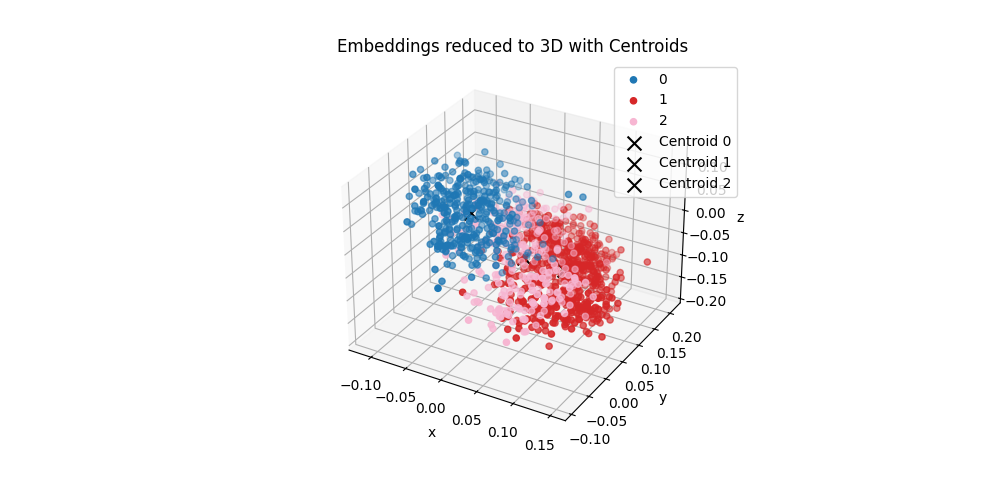

In [8]:
%matplotlib widget

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap("tab20")
categories = range(0, 3)

# Plot each sample category individually such that we can set label name
for i, cat in enumerate(categories):
    sub_matrix = np.array(df[df["cluster"] == cat]["3d_embedding"].to_list())
    x = sub_matrix[:, 0]
    y = sub_matrix[:, 1]
    z = sub_matrix[:, 2]
    colors = [cmap(i / len(categories))] * len(sub_matrix)
    ax.scatter(x, y, z, c=colors, label=cat)

# Calculate and plot centroids for each cluster
for cat in categories:
    sub_matrix = np.array(df[df["cluster"] == cat]["3d_embedding"].to_list())
    centroid = np.mean(sub_matrix, axis=0)
    ax.scatter(centroid[0], centroid[1], centroid[2], marker='x', s=100, c='black', label=f'Centroid {cat}')

ax.set_title('Embeddings reduced to 3D with Centroids')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))

plt.show()

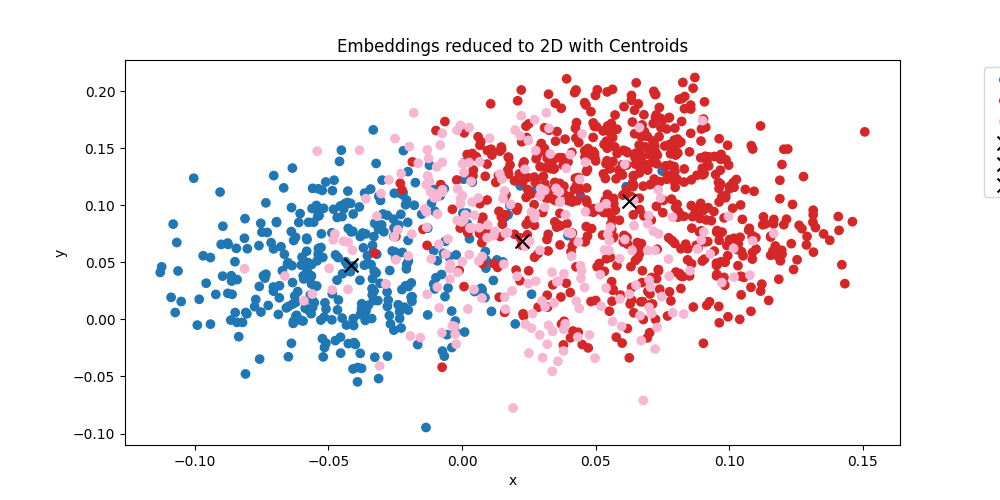

In [9]:
# Reduce embeddings to 2d, and plot
pca = PCA(n_components=2)
vis_dims = pca.fit_transform(X)
df["2d_embedding"] = vis_dims.tolist()
df["2d_embedding"][0]

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
cmap = plt.get_cmap("tab20")
categories = range(0, 3)

# Plot each sample category individually such that we can set label name.
for i, cat in enumerate(categories):
    sub_matrix = np.array(df[df["cluster"] == cat]["2d_embedding"].to_list())
    x = sub_matrix[:, 0]
    y = sub_matrix[:, 1]
    colors = [cmap(i / len(categories))] * len(sub_matrix)
    ax.scatter(x, y, c=colors, label=cat)

# Calculate and plot centroids for each cluster
for cat in categories:
    sub_matrix = np.array(df[df["cluster"] == cat]["2d_embedding"].to_list())
    centroid = np.mean(sub_matrix, axis=0)
    ax.scatter(centroid[0], centroid[1], marker='x', s=100, c='black', label=f'Centroid {cat}')

ax.set_title('Embeddings reduced to 2D with Centroids')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(bbox_to_anchor=(1.1, 1))

plt.show()


# Prepare the dataset for GPT

In [10]:
# Calculate distance to center of cluster for each sample
distance = []

for i, distances in enumerate(km.transform(X)):
    sample_cluster = df["cluster"].iloc[i]
    distance_to_cluster = distances[sample_cluster]
    distance.append(distance_to_cluster)
    
df["distance"] = distance
df.head()

,title,title_embedding,cluster,3d_embedding,2d_embedding,distance
0,AITA Monthly Open Forum Spooktober 2022,"[-0.0016421317122876644, -0.03590385988354683,...",9,"[0.038545695082348466, -0.04689246310868524, -...","[0.03824112695647822, -0.04625510874565932]",0.554206
1,AITA for asking my friend to move a picture of...,"[-0.008650328032672405, 0.006163689307868481, ...",11,"[0.025593940100869426, -0.06959358599009066, -...","[0.025801520694032097, -0.06957512567503356]",0.385608
2,AITA for asking my husband to stay with me whi...,"[0.006464043166488409, -0.01260389108210802, 0...",11,"[0.05173364814008891, 0.021756634172007586, -0...","[0.05178220856133653, 0.021969853658498035]",0.400645
3,AITA for telling my SIL to stop talking about ...,"[-0.012339530512690544, -0.01519016083329916, ...",15,"[-0.04601861739400734, 0.06438216303914424, -0...","[-0.04599091879310675, 0.06452530519388135]",0.358683
4,"AITA for wanting to meet my ""daughter"" after g...","[-0.003954039420932531, -0.010664722882211208,...",7,"[-0.08622125240020063, 0.05003138825870694, 0....","[-0.08615850470263144, 0.050181532897902184]",0.349584


In [11]:
# # Set your API key
# api_key = <key>
# openai.api_key = api_key

# reasons = []

# for k in range(0, 19):
#     posts = df.loc[df["cluster"] == k].sort_values(by="distance")["title"].values
        
#     question = f"I ran a clustering algorithm on embeddings of post titles on a subreddit called 'r/AmItheAsshole'. \
#         I'd like you to read through as many of these post titles as you can and sum up \
#         exactly ONE main reason why post submitters in this cluster are assholes. \
#         Please be as specific as possible, trying to avoid broad themes like selfishness and lack of empathy etc \
#         and instead opt for specific reasons like 'these people messed up weddings'. \
#         Avoid listing specific posts and commenting on the specific posts. \
#         As far as tone goes, please be as humorous and crass as possible. \
#         Here are the posts for cluster {k}: {posts[0:50]}"
    
#     try:
#         # Call the OpenAI API
#         response = openai.ChatCompletion.create(
#             model="gpt-3.5-turbo",
#             messages=[
#                 {"role": "user", "content": question},
#             ]
#         )
#     except Exception as e:
#         print(e)

#     # Extract and print the answer from the API response
#     answer = response.choices[0]["message"]["content"]
#     reasons.append(answer)
    
# with open('responses.pkl', 'wb') as f:
#         pickle.dump(reasons, f)
        
with open('data/responses.pkl', 'rb') as f:
        responses = pickle.load(f)
        
for i, reason in enumerate(responses):
    display(Markdown("\n---\n" + reason))


---
Cluster 0: AITA for being a controlling parent?

Main reason why post submitters in this cluster are assholes: These people think they have the right to control every aspect of their daughter's life, from who she sees to where she goes. They need to chill out and let their daughters live their lives. They're like overbearing dictators, but with less fashion sense and more unbrushed teeth.


---
Cluster 1: AITA for being a birthday party snubbing, family excluding, event skipping, celebration canceling, dinner refusing, relative rejecting, gathering dodging, invitation withholding, holiday avoiding, surprise party missing, friend abandoning, niece-nephew excluding, anniversary ignoring, in-law dodging, daughter's birthday party skipping, husband-wifey party segregationist, neighbor's kid shutting, cousin excluding asshole who just can't stand being around people during special occasions?


---
Cluster 2: 

The main reason post submitters in this cluster are assholes is because they constantly argue and fight with their spouses. These people seem to have never-ending conflicts with their partners, refusing to listen, disrespecting them, and blaming them for various issues. They display a complete disregard for their spouse's feelings and desires, constantly telling them off, cursing at them, and even going as far as involving others in their marital disputes. These individuals have a knack for making their partners uncomfortable, questioning their ability to provide for the family, and prioritizing their own needs over the relationship. Overall, they are a never-ending flame war waiting to happen within their marriages.


---
These assholes in Cluster 3 are a bunch of wedding-wrecking, invitation-withholding, family-excluding, friendship-denying, and destination-wedding-refusing jerks. They refuse to go to their sister's wedding, refuse to invite their sister to their own wedding, refuse to invite their fiancé's sister, aunt, parents, siblings, or mom to their wedding. They even refuse to let their sister bring her friend or friends to their wedding. They won't attend their daughter's wedding, uninvite their own sister, and won't go to their friend's wedding. These assholes cancel their own damn weddings, ditch their sisters' weddings, and don't invite their stepmothers or stepmothers again. In short, they're wedding drama creators who don't give a damn about anyone else's special day.


---
Cluster 4: The "Family Feud" Assholes

The main reason why post submitters in this cluster are assholes is that they seem to be constantly engaged in bitter family disputes. These individuals are airing their dirty laundry and causing drama with their siblings, often using hurtful language and making selfish decisions. They are refusing to help, kicking out, disinviting, or cutting off their own brothers and sisters over various issues. These assholes just can't seem to get along with their family members and are willing to cause chaos and animosity within their own bloodline. They are the masters of sibling rivalry and are not afraid to be heartless in their attempts to assert power and control over their family relationships. These cluster 4 assholes sure know how to turn family gatherings into a battlefield!


---
Cluster 5: AITA for being a gift-giving nightmare?

In this cluster, the main reason why these post submitters are assholes is because they consistently mishandle gift-giving situations. Whether it's refusing to give gifts, taking back gifts, giving gifts to someone else, or being ungrateful for gifts received, these individuals are causing major gift-giving offenses. They are like the Grinches of gift exchanges, spreading ungratefulness and selfishness instead of holiday cheer. So, if you're part of this cluster, better rethink your gift-giving etiquette because no one likes an asshole Santa.


---
Cluster 6: The Cluster of Selfish Housemates

It's time to delve into the world of self-centeredness and home turf battles! In this cluster, we encounter a group of individuals who believe that their homes are their castles, and they'll do whatever it takes to defend their personal space. These assholes are ready to go to war when it comes to allowing anyone, be it family, friends, or even their own parents, to invade their precious sanctuary. 

These folks aren't just your average, run-of-the-mill assholes; no, they take it to the next level in the realm of domestic dispute. They kick people out left and right, refusing to let parents, siblings, roommates, or even their own mothers live with them. They don't want anyone moving in, and they make sure to let it be known with their resounding "GTFO" attitude. 

These residents are like kings and queens guarding their majestic fortresses, rejecting requests from friends to move in, refusing to allow relatives to stay, and even evicting their moms from their own homes! They have a knack for instigating conflict by demanding that everyone pack their bags and find shelter elsewhere. 

So, if you're looking for a place to crash for a night, don't bother asking Cluster 6. These assholes have built their own exclusive club of "No house guests allowed," and they won't let anyone, no matter how close they are, tarnish their perfect little domestic kingdom.

Remember, when it comes to shelter and hospitality, these residents aren't just assholes; they're the pinnacle of self-serving, territorial assholery!


---
The main reason why post submitters in this cluster are assholes is that they are incredibly selfish and entitled when it comes to food. These individuals refuse to eat, share, or cook for others, they deny food to guests, they bring their own food to events, and even prevent their loved ones from eating what they paid for. They prioritize their own desires above basic social norms and common courtesy, making them a bunch of self-centered food-hoarding jerks.


---
Cluster 8: The Cluster of Workplace Troublemakers

One main reason why post submitters in this cluster are assholes is because they have a knack for creating chaos and conflict in the workplace. These assholes have a talent for getting their coworkers fired, scolding them, setting boundaries with them, refusing to help or cover for them, and generally causing a ruckus. They take pleasure in reporting their colleagues to HR, embarrassing them in front of others, and even intentionally trying to get them fired. They lack basic workplace etiquette, respect, and decency, leading to tense and uncomfortable environments. These workplace troublemakers are the true assholes of r/AmItheAsshole.


---
Cluster 9: AITA for being a stingy money hoarder?

Main reason: These assholes refuse to give or lend money to their family members, friends, and even their own children. They prioritize their own financial gain over helping others in need. They're like the Scrooge McDucks of the subreddit, swimming in a pool of their own greed. They'd rather see their loved ones drowning in debt than parting with a single penny. Christmas presents from them probably consist of a handshake and a reminder to pay them back for that slice of cake at last year's picnic.


---
Based on the titles in Cluster 10 of the 'r/AmItheAsshole' subreddit, it seems that the main reason why post submitters in this cluster are assholes is that they frequently engage in confrontations and conflicts with their friends or neighbors. They express anger, refuse to apologize, dismiss others, insult or embarrass people, refuse to forgive, and even get the cops called on them. They show a lack of consideration for others and often prioritize their own feelings and opinions over maintaining positive relationships. Essentially, these individuals tend to be abrasive and difficult to get along with, leading them to be labeled as assholes in their social interactions.


---
Cluster 11: AITA for being a bathroom tyrant?

In this cluster, the main reason why post submitters are assholes is their obsession with controlling and manipulating bathroom access and cleanliness. These individuals believe that the bathroom is exclusively theirs and refuse to share, clean up after themselves, or tolerate anyone else using it. They have no consideration for others and prioritize their own comfort and convenience over basic human needs. They would rather cause conflicts and inconvenience others than compromise or contribute to a harmonious living environment. These bathroom tyrants need a reality check and some serious toilet etiquette lessons.


---
These post submitters are assholes because they constantly prioritize their own wants and needs over the important events and relationships of their loved ones. Whether it's refusing to attend their daughter's birthday party, not going to their sister's wedding, or kicking out their parents, these individuals consistently demonstrate a complete lack of consideration for others. They selfishly prioritize their own desires, causing unnecessary tension and damaging their relationships. It's like they have a black hole of self-centeredness that sucks in all the joy and harmony from their family and social interactions. They should probably invest some time in learning how to be less of an asshole and more of a decent human being.


---
Cluster 13: Inconsiderate and Controlling Partners

The main reason why post submitters in this cluster are assholes is that they consistently display inconsiderate and controlling behavior within their relationships. Whether it's refusing to compromise, not listening to their partner's wishes, or telling them to shut up, these individuals consistently prioritize their own wants and needs over their partner's. They manipulate situations to make their partners feel bad, make them cry, or even kick them out. They often disrespect and belittle their partners, telling them they don't deserve respect or insisting on controlling their actions and interactions. These assholes think they have the right to make decisions for their partners, whether it's forbidding them from seeing family, friends, or even sitting next to someone else. They engage in manipulative tactics such as hiding things, deliberately making their partners feel exposed or stranded, and intentionally causing arguments and meltdowns. Overall, their behavior reflects a lack of consideration, empathy, and respect for their partners, making them major assholes within their relationships.


---
Cluster 14: Post submitters in this cluster are assholes because they constantly involve themselves in intense sibling drama and conflicts, creating a toxic environment within their family. They argue, kick out, and undermine their sisters, refuse to help or accommodate their siblings, and even ban their own nieces from their homes. These individuals seem to prioritize their own opinions and desires over maintaining healthy relationships with their sisters, causing unnecessary strife and tension. They need to take a step back and learn to communicate and resolve conflicts in a more mature and respectful manner instead of continuously fueling the fire. Maybe they should consider taking a sibling rivalry management course or invest in a good pair of noise-canceling headphones to drown out the constant bickering.


---
Post submitters in cluster 15 are assholes because they prioritize their own individual desires and preferences over the well-being and inclusion of their family members on vacations. They refuse to invite family members, exclude them from trips, and even cancel their vacations, showing a lack of consideration and selfishness. These assholes care more about their own enjoyment than creating meaningful and inclusive experiences for their loved ones.


---
Cluster 16: The "Mom Drama" Cluster

Main Reason: These post submitters are assholes because they can't seem to handle their complicated relationships with their mothers without resorting to disrespectful behavior and hurtful actions. Whether it's refusing to help their mom, swearing at her, or even telling her to go f*** herself, these individuals have displayed a remarkable talent for exacerbating family tensions. Instead of fostering open communication and trying to resolve issues, they choose to escalate the situation with crass and disrespectful behavior. It's like watching a never-ending soap opera of dysfunctional family dynamics unfold before our very eyes. So, congratulations to this cluster for taking the "mom drama" to a whole new level of assholery!


---
Cluster 17: This cluster is full of entitled, baby-obsessed assholes who think the world revolves around their pregnancy and new baby. They refuse to help their family, banish pregnant relatives, forbid anyone from holding their precious child, and even blame others for their infertility. These assholes are just a bunch of self-centered baby tyrants who believe everyone should cater to their every whim.


---
The main reason why post submitters in cluster 18 are assholes is because they prioritize their own interests and desires over the well-being and needs of their children. They refuse to punish their son, defend him when he's in the wrong, and even take him away from his grandparents. They don't want their son to interact with certain relatives or have any responsibilities, while also controlling who he can spend time with. Additionally, they kick him out, withhold him from family members, and use inappropriate language to insult him. In short, they consistently display selfish and negligent behavior, disregarding the impact on their child's upbringing and emotional development. These individuals are definitely assholes when it comes to parenting.